# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [3]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [4]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 7ms/step - loss: 1.5221 - accuracy: 0.6361
Epoch 2/50
180/180 [==============================] - 1s 5ms/step - loss: 0.3389 - accuracy: 0.8664
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2172 - accuracy: 0.9165: 0s - loss:
Epoch 4/50
180/180 [==============================] - 1s 4ms/step - loss: 0.1748 - accuracy: 0.9382
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1477 - accuracy: 0.9482
Epoch 6/50
180/180 [==============================] - 1s 4ms/step - loss: 0.1299 - accuracy: 0.9505
Epoch 7/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1177 - accuracy: 0.9516
Epoch 8/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1040 - accuracy: 0.9633
Epoch 9/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9638
Epoch 10/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0848 - accu

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [5]:
#first train/test split
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)
#split training again into another set for normalization
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)
#normalize by dividing by max value of 16
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to? - The dimension of the tensor (check with .shape)
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7043 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7facbac10880>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7123245000839233,
   0.7091560959815979,
   0.7064180970191956,
   0.7043173909187317,
   0.7025619745254517,
   0.7012463212013245,
   0.7001783847808838,
   0.6992278695106506,
   0.6985119581222534,
   0.6978591084480286],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

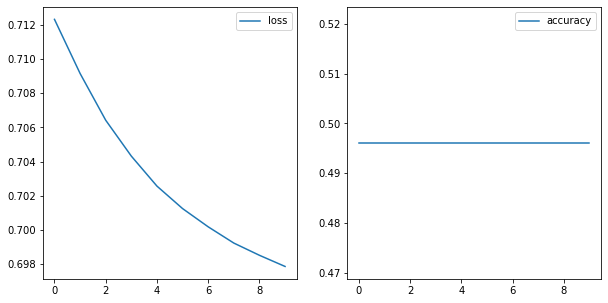

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [9]:
X_pure_train.shape[0]

1149

In [10]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.7015
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.7015
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.6989
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.7354
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.7659
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7920
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5416 - accuracy: 0.8024
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.8129
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5018 - accuracy: 0.8268
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 0.8338
Epoch 11/

36/36 [==============================] - 0s 3ms/step - loss: 0.1459 - accuracy: 0.9399
Epoch 84/100
36/36 [==============================] - 1s 17ms/step - loss: 0.1444 - accuracy: 0.9417 0s - loss: 0.1663 - ac
Epoch 85/100
36/36 [==============================] - 0s 9ms/step - loss: 0.1423 - accuracy: 0.9426
Epoch 86/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1412 - accuracy: 0.9417
Epoch 87/100
36/36 [==============================] - 1s 19ms/step - loss: 0.1406 - accuracy: 0.9434
Epoch 88/100
36/36 [==============================] - 0s 10ms/step - loss: 0.1380 - accuracy: 0.9460
Epoch 89/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1374 - accuracy: 0.9452
Epoch 90/100
36/36 [==============================] - 0s 13ms/step - loss: 0.1357 - accuracy: 0.9469
Epoch 91/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1345 - accuracy: 0.9426
Epoch 92/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1337 - acc

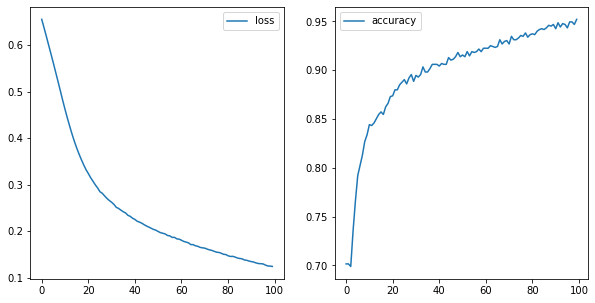

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 3ms/step - loss: 8.0354 - accuracy: 0.5022
Epoch 2/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0880 - accuracy: 0.4909
Epoch 3/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9588 - accuracy: 0.5013
Epoch 4/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0024 - accuracy: 0.4961
Epoch 5/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9965 - accuracy: 0.5083
Epoch 6/30
115/115 [==============================] - 0s 3ms/step - loss: 1.1088 - accuracy: 0.4726
Epoch 7/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0239 - accuracy: 0.4935
Epoch 8/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9345 - accuracy: 0.5239
Epoch 9/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9600 - accuracy: 0.4961
Epoch 10/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9530 - accuracy: 0.4996

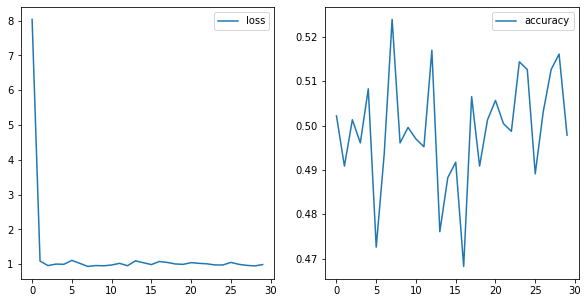

In [12]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 1s 10ms/step - loss: 0.6954 - accuracy: 0.5152 - val_loss: 0.6341 - val_accuracy: 0.5938
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5886 - accuracy: 0.7171 - val_loss: 0.5190 - val_accuracy: 0.8472
Epoch 3/30
115/115 [==============================] - 0s 4ms/step - loss: 0.4821 - accuracy: 0.8529 - val_loss: 0.4352 - val_accuracy: 0.9028
Epoch 4/30
115/115 [==============================] - 1s 5ms/step - loss: 0.4155 - accuracy: 0.8999 - val_loss: 0.3803 - val_accuracy: 0.9236
Epoch 5/30
115/115 [==============================] - 0s 4ms/step - loss: 0.3715 - accuracy: 0.9234 - val_loss: 0.3394 - val_accuracy: 0.9375
Epoch 6/30
115/115 [==============================] - 0s 4ms/step - loss: 0.3373 - accuracy: 0.9304 - val_loss: 0.3153 - val_accuracy: 0.9271
Epoch 7/30
115/115 [==============================] - 0s 4ms/step - loss: 0.3096 - accuracy: 0.9408 - val_loss: 0.2868 - val_accuracy: 0.9444
Epoch

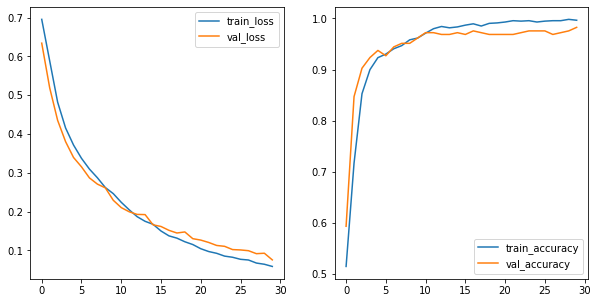

In [13]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10,
                   verbose=1, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [14]:
results.history['val_accuracy'][-1]

0.9826388955116272

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [15]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7facbbe2ed00> does not.

In [16]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
#KerasClassifier reads the model function through the sklearn wrapper - acts as a .fit method
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [18]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [19]:
#because this is a cross_val through SKlearn, it will run the epochs 5 times - so 50X5 for the cross val
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 0s - loss: 0.6473 - accuracy: 0.5473
Epoch 2/50
29/29 - 0s - loss: 0.6013 - accuracy: 0.6431
Epoch 3/50
29/29 - 0s - loss: 0.5538 - accuracy: 0.7780
Epoch 4/50
29/29 - 0s - loss: 0.5118 - accuracy: 0.8074
Epoch 5/50
29/29 - 0s - loss: 0.4757 - accuracy: 0.8390
Epoch 6/50
29/29 - 0s - loss: 0.4457 - accuracy: 0.8683
Epoch 7/50
29/29 - 0s - loss: 0.4157 - accuracy: 0.8945
Epoch 8/50
29/29 - 0s - loss: 0.3881 - accuracy: 0.9053
Epoch 9/50
29/29 - 0s - loss: 0.3552 - accuracy: 0.9217
Epoch 10/50
29/29 - 0s - loss: 0.3136 - accuracy: 0.9304
Epoch 11/50
29/29 - 0s - loss: 0.2655 - accuracy: 0.9369
Epoch 12/50
29/29 - 0s - loss: 0.2219 - accuracy: 0.9434
Epoch 13/50
29/29 - 0s - loss: 0.1927 - accuracy: 0.9434
Epoch 14/50
29/29 - 0s - loss: 0.1746 - accuracy: 0.9521
Epoch 15/50
29/29 - 0s - loss: 0.1563 - accuracy: 0.9489
Epoch 16/50
29/29 - 0s - loss: 0.1439 - accuracy: 0.9576
Epoch 17/50
29/29 - 0s - loss: 0.1341 - accuracy: 0.9576
Epoch 18/50
29/29 - 0s - loss: 0.1264 - 

Epoch 44/50
29/29 - 0s - loss: 0.0454 - accuracy: 0.9880
Epoch 45/50
29/29 - 0s - loss: 0.0439 - accuracy: 0.9880
Epoch 46/50
29/29 - 0s - loss: 0.0409 - accuracy: 0.9891
Epoch 47/50
29/29 - 0s - loss: 0.0424 - accuracy: 0.9880
Epoch 48/50
29/29 - 0s - loss: 0.0378 - accuracy: 0.9924
Epoch 49/50
29/29 - 0s - loss: 0.0380 - accuracy: 0.9891
Epoch 50/50
29/29 - 0s - loss: 0.0351 - accuracy: 0.9946
8/8 - 0s - loss: 0.0944 - accuracy: 0.9609
Epoch 1/50
29/29 - 0s - loss: 0.6388 - accuracy: 0.6790
Epoch 2/50
29/29 - 0s - loss: 0.5646 - accuracy: 0.7748
Epoch 3/50
29/29 - 0s - loss: 0.4770 - accuracy: 0.8270
Epoch 4/50
29/29 - 0s - loss: 0.3922 - accuracy: 0.8466
Epoch 5/50
29/29 - 0s - loss: 0.3374 - accuracy: 0.8629
Epoch 6/50
29/29 - 0s - loss: 0.2967 - accuracy: 0.8770
Epoch 7/50
29/29 - 0s - loss: 0.2734 - accuracy: 0.8825
Epoch 8/50
29/29 - 0s - loss: 0.2546 - accuracy: 0.8945
Epoch 9/50
29/29 - 0s - loss: 0.2381 - accuracy: 0.8977
Epoch 10/50
29/29 - 0s - loss: 0.2241 - accuracy: 0.90

array([0.96956521, 0.95217389, 0.96086955, 0.96956521, 0.96506548])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

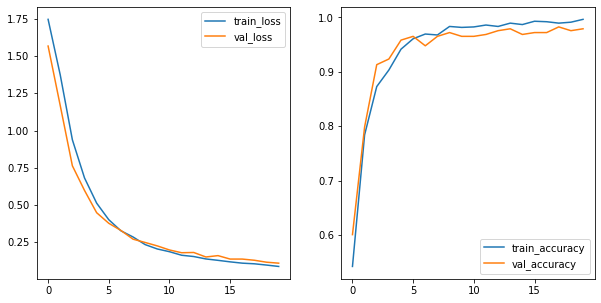

In [20]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

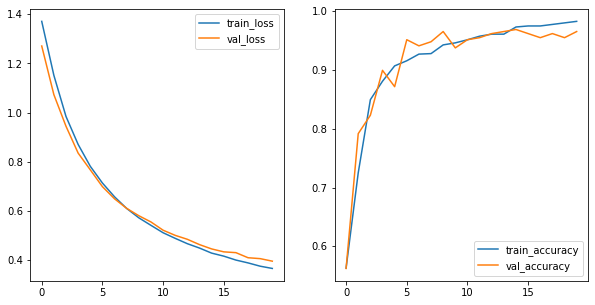

In [21]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](img/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

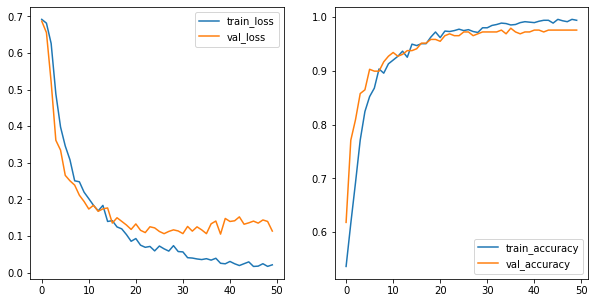

In [24]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [25]:
results.history['val_accuracy'][-1]

0.9756944179534912

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00017: early stopping


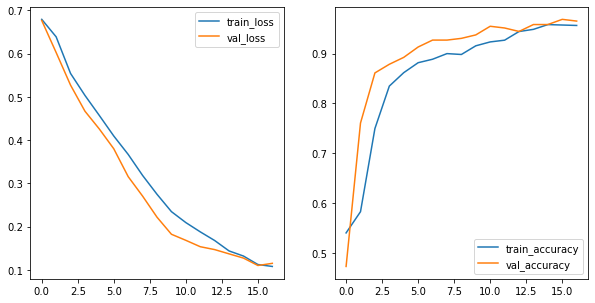

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00036: early stopping


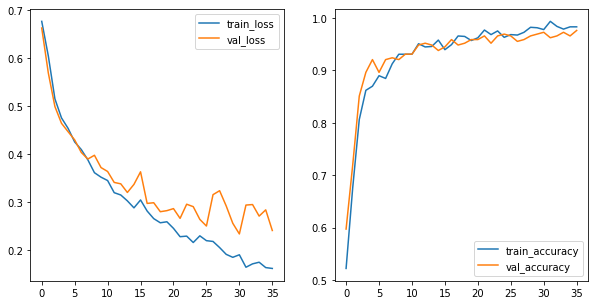

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=5, verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [28]:
results.history['val_accuracy'][-1]

0.9756944179534912

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [29]:
digits = load_digits()
X = digits.data
y = digits.target

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [31]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [32]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 6ms/step - loss: 2.1906 - accuracy: 0.1584 - val_loss: 2.0626 - val_accuracy: 0.2674
Epoch 2/50
115/115 [==============================] - 1s 5ms/step - loss: 1.9587 - accuracy: 0.3142 - val_loss: 1.8103 - val_accuracy: 0.3889
Epoch 3/50
115/115 [==============================] - 1s 9ms/step - loss: 1.6943 - accuracy: 0.4369 - val_loss: 1.5420 - val_accuracy: 0.5174
Epoch 4/50
115/115 [==============================] - 1s 10ms/step - loss: 1.4298 - accuracy: 0.5622 - val_loss: 1.3083 - val_accuracy: 0.6285
Epoch 5/50
115/115 [==============================] - 1s 9ms/step - loss: 1.1878 - accuracy: 0.6719 - val_loss: 1.0697 - val_accuracy: 0.7222
Epoch 6/50
115/115 [==============================] - 1s 8ms/step - loss: 0.9628 - accuracy: 0.7763 - val_loss: 0.8901 - val_accuracy: 0.7674
Epoch 7/50
115/115 [==============================] - 1s 12ms/step - loss: 0.7839 - accuracy: 0.8207 - val_loss: 0.7480 - val_accuracy: 0.7951
Epoc

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [34]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

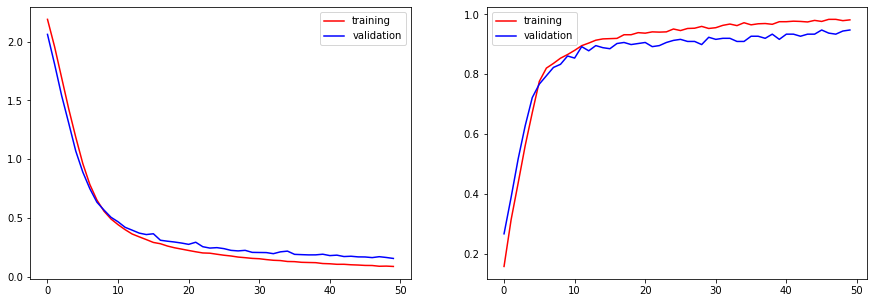

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [36]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [37]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  0,  0,  1,  1,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2, 29,  1,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 1,  1,  0,  0, 44,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  1,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 32,  1,  1],
       [ 0,  0,  1,  0,  1,  1,  0,  0, 27,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  1, 37]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
